# Target configuration

In [1]:
# Target configuration
conf = {
    
    # Target type
    "platform"    : 'linux',
    "board"       : "sabre",
    
    # Login credentials
    "host"        : "192.168.10.135",
    "username"    : "root",
    "password"    : "temppwd",

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "sched_wakeup_new",
             "sched_wakeup",
             "sched_deadline_suspend",
             "sched_deadline_replenish",
             "cpu_frequency",
             "sched_dl_grub",
             "sched_load_avg_task",
         ],
         "buffsize" : 10240
    },
    
    "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '192.168.10.118',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
        }
    },
}

cpu_number = 4

In [2]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
# Execute this cell to enabled devlib debugging statements
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [4]:
# Generate plots inline
%pylab inline

# Other python modules required by this notebook
import json
import os
import shutil

Populating the interactive namespace from numpy and matplotlib


In [5]:
 #Support to access the remote target
from env import TestEnv

# Initialize a test environment
te = TestEnv(conf)
target = te.target

/usr/lib/python2.7/dist-packages/gtk-2.0/gtk/__init__.py:57: GtkWarning: could not open display
  warnings.warn(str(e), _gtk.Warning)
08:44:43  WARNING : Unusual max capacity (1023), overriding capacity_scale
08:44:43  INFO    : Using base path: /lisa
08:44:43  INFO    : Loading custom (inline) target configuration
08:44:43  DEBUG   : Target configuration {'username': 'root', 'platform': 'linux', 'host': '192.168.10.135', 'ftrace': {'buffsize': 10240, 'events': ['sched_switch', 'sched_wakeup_new', 'sched_wakeup', 'sched_deadline_suspend', 'sched_deadline_replenish', 'cpu_frequency', 'sched_dl_grub', 'sched_load_avg_task']}, 'board': 'sabre', 'password': 'temppwd', 'tools': ['taskset', 'trace-cmd'], 'emeter': {'instrument': 'acme', 'channel_map': {'Device0': 0}, 'conf': {'iio-capture': '/usr/bin/iio-capture', 'ip_address': '192.168.10.118'}}}
08:44:43  DEBUG   : Trying to load board descriptor from /lisa/libs/utils/platforms/sabre.json
08:44:43  INFO    : Loading board:
08:44:43  INFO  

In [6]:
def execute(te, target_test_dir, target_test_command, target_res_dir, host_res_dir):
    
    logging.info('# Create results folder for this execution')
    !rm -fr {host_res_dir}
    !mkdir {host_res_dir}

    logging.info('### Entering directory...')
    te.target.execute("cd " + target_test_dir)
    
    logging.info('## Start energy sampling')
    te.emeter.reset()   
    
    logging.info('### Running command...')
    te.target.execute(target_test_command)
  
    #logging.info('## Read energy consumption: %s/energy.json', host_res_dir)
    # This also creates the Samples file
    nrg_report = te.emeter.report(out_dir=host_res_dir)

    host_trace_file = os.path.join(host_res_dir, 'trace.dat')
    target_trace_file = os.path.join(target_res_dir, 'trace.dat')
    logging.info('# Save FTrace: %s', host_trace_file)
    te.ftrace.target.pull(target_trace_file, host_res_dir, timeout=100)
 
    logging.info('# Save platform description: %s/platform.json', host_res_dir)
    plt, plt_file = te.platform_dump(host_res_dir)
    
    logging.info('# Report collected data:')
    logging.info('   %s', host_res_dir)
    !ls -la {host_res_dir}
    
    return plt, plt_file, host_trace_file, nrg_report

# Test (schedutil)

In [7]:
# Test name
#test_name = "T0015-fixed-load"
test_name = "T0005-change-param-run"
#test_name = "T0003-two-tasks"

# Set schedutil governor
target.cpufreq.set_all_governors('schedutil')

# Target's main directory containing the testsuite 
target_test_dir ="/home/ubuntu/test-dl/"

# Target's command to run the test
target_test_command = "sudo ./run.sh " + test_name

# Target's command to run the test
target_res_dir = os.path.join("/home/ubuntu/test-dl/", test_name);

# Host's directory that will contain the test results
host_res_dir = "/tmp/test-dl/"

08:44:54  DEBUG   : /root/devlib-target/bin/shutils cpufreq_set_all_governors schedutil


In [8]:
plt, plt_file, trace_file, nrg_report = execute(te, target_test_dir, target_test_command, target_res_dir, host_res_dir)

08:44:54  INFO    : # Create results folder for this execution
08:44:54  INFO    : ### Entering directory...
08:44:54  DEBUG   : cd /home/ubuntu/test-dl/
08:44:54  INFO    : ## Start energy sampling
08:44:55  DEBUG   : Started /usr/bin/iio-capture on Device0 (iio:device0)...
08:44:55  INFO    : ### Running command...
08:44:56  DEBUG   : sudo ./run.sh T0005-change-param-run
08:45:24  DEBUG   : Completed IIOCapture for Device0 (iio:device0)...
08:45:24  DEBUG   : Device0 (iio:device0)
08:45:24  DEBUG   : {'cmin': 340.0, 'energy': 52361.5, 'pavg': 2234.17, 'pmin': 1725.0, 'vmax': 5067.5, 'cmax': 871.0, 'pmax': 4225.0}
08:45:24  INFO    : # Save FTrace: /tmp/test-dl/trace.dat
08:45:24  DEBUG   : /usr/bin/scp -r   root@192.168.10.135:/home/ubuntu/test-dl/T0005-change-param-run/trace.dat /tmp/test-dl/
08:45:25  INFO    : # Save platform description: /tmp/test-dl//platform.json
08:45:25  DEBUG   : Dump platform descriptor in [/tmp/test-dl/platform.json]
08:45:25  INFO    : # Report collected 

total 4648
drwxrwxr-x  2 lisa lisa    4096 Jun 20 08:45 .
drwxrwxrwt 24 root root    4096 Jun 20 08:44 ..
-rw-rw-r--  1 lisa lisa      26 Jun 20 08:45 energy.json
-rw-rw-r--  1 lisa lisa     201 Jun 20 08:45 energy_stats.json
-rw-rw-r--  1 lisa lisa     748 Jun 20 08:45 platform.json
-rw-rw-r--  1 lisa lisa  182426 Jun 20 08:45 samples_Device0.csv
-rw-r--r--  1 lisa lisa 4554752 Jun 20 08:45 trace.dat


In [9]:
!kernelshark {trace_file} 2>/dev/null

In [10]:
# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

In [11]:
# Parse trace
# This will create trace.txt
tr = Trace(te.platform, 
           host_res_dir,
           events=conf['ftrace']['events'])

08:45:26  DEBUG   : Loading [sched] events from trace in [/tmp/test-dl/]...
08:45:26  DEBUG   : Parsing events: ['sched_switch', 'sched_wakeup_new', 'sched_wakeup', 'sched_deadline_suspend', 'sched_deadline_replenish', 'cpu_frequency', 'sched_dl_grub', 'sched_load_avg_task', 'cpu_frequency_devlib']
08:45:26  DEBUG   : Parsing FTrace format...
08:45:26  DEBUG   : Events found on trace:
08:45:26  DEBUG   :  - sched_dl_grub
08:45:26  DEBUG   :  - cpu_frequency
08:45:26  DEBUG   :  - sched_wakeup_new
08:45:26  DEBUG   :  - sched_switch
08:45:26  DEBUG   :  - sched_wakeup
08:45:26  DEBUG   : Lookup dataset for tasks...
08:45:26  DEBUG   : Lookup for task [swapper/0]...
08:45:26  DEBUG   :   task        swapper/0 found, pid: [0]
08:45:26  DEBUG   : Lookup for task [run.sh]...
08:45:26  DEBUG   :   task           run.sh found, pid: [21111, 21121, 21122, 21124, 21125, 21126, 21127, 21128]
08:45:26  DEBUG   : Lookup for task [rcu_sched]...
08:45:26  DEBUG   :   task        rcu_sched found, pid:

08:45:27  DEBUG   :    trace_event
08:45:27  DEBUG   :    eas


### Plot frequency

08:45:27  WARNING : Event [sched_overutilized] not found, plot DISABLED!
08:45:27  INFO    : CPU00 average frequency: 0.894 GHz
08:45:27  WARNING : Event [sched_overutilized] not found, plot DISABLED!
08:45:27  INFO    : CPU01 average frequency: 0.894 GHz
08:45:27  WARNING : Event [sched_overutilized] not found, plot DISABLED!
08:45:27  INFO    : CPU02 average frequency: 0.894 GHz
08:45:27  WARNING : Event [sched_overutilized] not found, plot DISABLED!
08:45:27  INFO    : CPU03 average frequency: 0.894 GHz


{0: 0.89400000000000002,
 1: 0.89400000000000002,
 2: 0.89400000000000002,
 3: 0.89400000000000002}

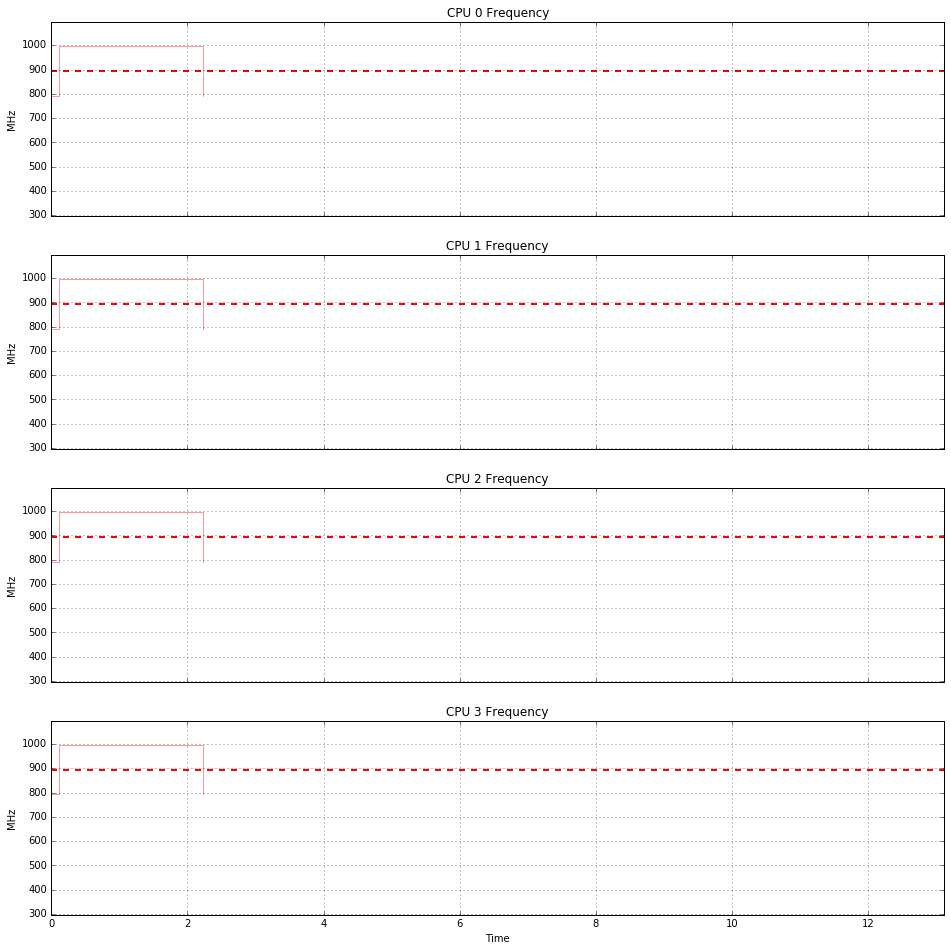

In [12]:
tr.analysis.frequency.plotCPUFrequencies()

### Plot execution

In [13]:
#tr.analysis.tasks.plotTasks()

In [14]:
df = tr.ftrace.sched_switch.data_frame
a = df[df['__comm'].str.contains('T00')][['__pid']]
pids_set=set([])
for i in a.index:
    pid = a.get_value(i, '__pid')
    #print "Adding pid ", pid
    if isinstance(pid, int):
        pids_set.add(pid)
pids_list=list(pids_set)
#print "Plotting pids: ", pids_list
trappy.plotter.plot_trace(host_res_dir, "", pids_list)

### Plot GRUB total and active bw

In [15]:
for i in range (0, cpu_number):
    try:
        trappy.ILinePlot(tr.ftrace,
                signals=[
                            "sched_dl_grub:total_bw:0x0,0x0,0xff",
                            "sched_dl_grub:running_bw:0x0,0xff,0x0",
                ],
                pivot="cpu_id",
                filters={"cpu_id": [i]},
                marker = '+',
                drawstyle='steps-post',
                per_line=1).view()
    except Exception, err:
        print "No data for cpu ", i, " ", err

No data for cpu  0   No plots for the given constraints
No data for cpu  1   No plots for the given constraints
No data for cpu  2   No plots for the given constraints


""
""


In [16]:
import pandas as pd

df = pd.DataFrame(list(nrg_report.channels.iteritems()),
                  columns=['Cluster', 'Energy'])
df = df.set_index('Cluster')
df

,Energy
Cluster,
Device0,52361.5


In [17]:
def plotPower(csv, tmin=0, tmax=None):
    # Parse CSV and set reasonable names for the columns
    columns=["vshunt_mV", "vbus_mV", "power_mW", "current_mA", "ms"]
    df = pd.read_csv(csv, names=columns, index_col=4, skiprows=1)
    # Scale index to have [s] resolution
    df['Time'] = df.index / 1e3
    df.set_index('Time', inplace=True)
    # Plot the dataframe in the required Time range
    ax = df.power_mW.plot(figsize=(16,8), drawstyle='steps-post', style=['r-'], alpha=0.4, xlim=(tmin, tmax))
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Power [mW]")

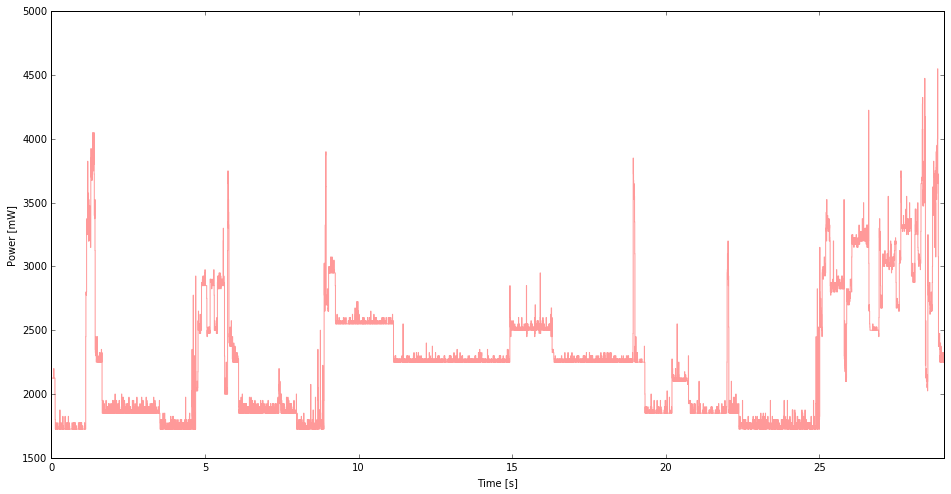

In [18]:
plotPower('/tmp/test-dl/samples_Device0.csv')